___
## Random Forest for VEE Prediction
___

#### Predicting Vertical Exciation Energies of Propanol in gas phase using Random Forest Regressor with
#### Coulomb Matrix as input features
___

In [12]:
# Import Libraries
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

____
## Required Functions
____

In [3]:
# Dictionary of atomic numbers (expand as needed)
atomic_numbers = {'H': 1, 'C': 6, 'N': 7, 'O': 8}

def create_coulomb_matrix(xyz, max_atoms=15):
    """Create a Coulomb Matrix from XYZ coordinates."""
    n_atoms = len(xyz)
    m = np.zeros((max_atoms, max_atoms))
    for i in range(n_atoms):
        for j in range(n_atoms):
            if i == j:
                m[i, j] = 0.5 * xyz[i][0] ** 2.4  # Diagonal elements
            else:
                dist = np.linalg.norm(xyz[i][1:] - xyz[j][1:])
                m[i, j] = xyz[i][0] * xyz[j][0] / dist  # Off-diagonal elements
    return m.flatten()

def load_data(xyz_file, energy_file, max_atoms=15):
    """Load XYZ configurations and energies, create Coulomb Matrices."""
    # Load XYZ configurations (assuming a simple format)
    with open(xyz_file, 'r') as f:
        xyz_data = f.read().split('\n\n')
    
    X = []
    for molecule in xyz_data:
        lines = molecule.strip().split('\n')[2:]  # Skip atom count and comment
        xyz = np.array([[atomic_numbers[line.split()[0]]] + [float(x) for x in line.split()[1:]] for line in lines])
        X.append(create_coulomb_matrix(xyz, max_atoms))
    
    # Load energies
    y = np.loadtxt(energy_file)
    
    return np.array(X), y

____
## Load, Preprocess and Split Data
___

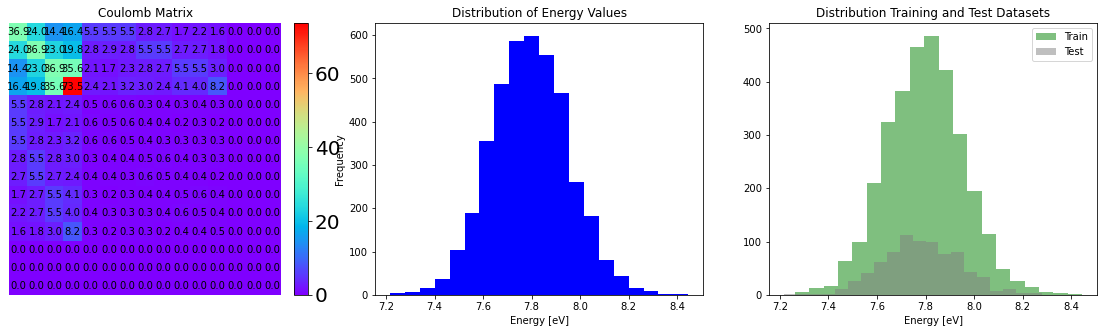

In [20]:
# Load and preprocess and Visualise data
X, y = load_data('cleaned_reimaged_heat.xyz', 's1_excitation_energy.dat')

# Visualize the Coulomb matrix of a random configuration
shape = (15, 15)
rand_mol = np.random.randint(0, len(X))
mat = X[rand_mol].reshape(shape).round(1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot Random Coulomb Matrix and
# Histogram of VEEs
fig, axs = plt.subplots(1, 3, figsize = (20,5))
axs = axs.ravel()

axs[0].set_title('Coulomb Matrix')
axs[0].imshow(mat, origin="upper", cmap='rainbow', vmin=X[rand_mol].min(), vmax=X[rand_mol].max(), interpolation='nearest')
colorbar = axs[0].figure.colorbar(axs[0].images[0], ax=axs[0], fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=20)
axs[0].axis('off')
for i in range(15):
    for j in range(15):
        c = mat[j, i]
        axs[0].text(i, j, str(f'{c}'), va="center", ha="center")

axs[1].set_title('Energy')
axs[1].hist(y, bins=20, color='blue')
axs[1].set_xlabel('Energy [eV]')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Energy Values')

# Visualize Training and Test Sets
# To See How Closely Their Distribution Matches
axs[2].hist(y_train, bins=20, color='green', alpha=0.5, label='Train')
axs[2].hist(y_test, bins=20, color='grey', alpha=0.5, label='Test')
axs[2].set_xlabel('Energy [eV]')
axs[2].set_title('Distribution Training and Test Datasets')
axs[2].legend()
plt.show()

____
## Train, Save and Load RndFrst Model
___

In [10]:
# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


# Save the model
joblib.dump(rf_model, 'rf_model.pkl')

# Load the model
rf_model = joblib.load('rf_model.pkl')

____
## Make Predictions and Evaluate Model
___

In [6]:
# Make predictions
y_pred = rf_model.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

____
## Plot Predictions
____

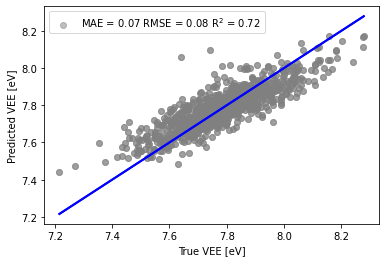

In [7]:
plt.scatter(y_test, y_pred, color='grey', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linewidth=2) 
plt.scatter(y_test, y_pred, color='grey', alpha=0.5, label=fr'MAE = {mae:.2f} RMSE = {rmse:.2f} R$^2$ = {r2:.2f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linewidth=2) 
plt.xlabel('True VEE [eV]')
plt.ylabel('Predicted VEE [eV]')
#plt.title(f'Random Forest: MAE = {mae:.2f}, RMSE = {rmse:.2f})
plt.legend()
plt.show()

In [8]:
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error: {rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': range(X.shape[1]),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Mean Absolute Error: 0.0664
Root Mean Square Error: 0.0844

Top 10 Most Important Features:
     feature  importance
166      166    0.196518
26        26    0.189155
174      174    0.046099
161      161    0.044349
175      175    0.041525
146      146    0.039316
165      165    0.034886
11        11    0.034229
55        55    0.018556
153      153    0.016810
